In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

index_name = ["S",'V','L',"BET",'Vt','Temp(K)',"K","n",'Vmic']
def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    data_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_data = pd.read_csv(os.path.join(source_path,file_name+'-fitting-02-01-2022.csv'))
        temp_data = temp_data.dropna(axis=0,how = 'any',subset = ["BET","Vt",'Vmic'])
        temp_data = temp_data[index_name]
        
        data_df = pd.concat([data_df,temp_data],axis =0)
        
    return data_df

In [52]:
data_set = pred_dataset(['CO2']) #'Methane','Ethane&Ethylene','CFCs'

In [95]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
  
n_estimators = [50,100,120,150,180,200]

# define different models#('SVR',SVR(max_iter=10000)),
models =[
        ('RF',RandomForestRegressor(n_jobs=-1,random_state=42)),
        # ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42))
         ]

# set search parameters grid for different models
para_grids = {
    'RF':{'RF__n_estimators':n_estimators},\
    'LGBM':{'LGBM__num_leaves':[10,20,30,40,50,60],'LGBM__learning_rate': [0.05,0.1,0.5,1],
    'LGBM__n_estimators':n_estimators}
    }


In [63]:
from sklearn.model_selection import GridSearchCV,cross_validate,GroupKFold
from sklearn.ensemble import ExtraTreesRegressor
from  sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle
#new codes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def para_convert(results,model_name):
    best = results.best_params_
    keys = list(results.best_params_.keys())
    new_keys = {key[len(model_name)+2:]:best[key] for key in keys}
    return new_keys

def model_CV(train_x,train_y,model,model_name,para_grid):
    #new codes
    scaler = StandardScaler()
    pipe = Pipeline(steps = [('scaler',scaler),(model_name,model)])
    result = GridSearchCV(pipe,para_grid,cv= 5,scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
    result.fit(train_x,train_y)
    best_params = para_convert(result,model_name)
    
    #model_refit =model.set_params(**result.best_params_)
    model_refit = model.set_params(**best_params)
    train_cv = cross_validate(model_refit,train_x,train_y,cv =5,scoring = ('r2', 'neg_mean_squared_error'))
    train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
    train_r2_cv = train_cv['test_r2'].mean()
    
    return [train_r2_cv,train_mse_cv], best_params

In [96]:
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor


features_importance = []
for i in range(200):
    train_sample = data_set.sample(n = int(len(data_set)*0.1))
    mse_cv = 10
    forest_importance = []
    for model_name, model in models:

        result_cv,best_params = model_CV(train_sample.iloc[:,3:-1],train_sample.iloc[:,-1],model,model_name,para_grids[model_name])
        print(result_cv)
        opt_model = model.set_params(**best_params) 
        train_x = StandardScaler().fit_transform(train_sample.iloc[:,3:-1])
        train_y = train_sample.iloc[:,-1]
        opt_model.fit(train_x,train_y)
        result = permutation_importance(opt_model,train_x,train_y, n_repeats=10, random_state=42, n_jobs=2)
        forest_importances = pd.Series(result.importances_mean, index = index_name[3:-1])
        if model_name == "LGBM":
            forest_importances = opt_model.feature_importances_
        if result_cv[-1]<mse_cv:
            mse_cv = result_cv[-1]
            forest_importance = forest_importances
        print(forest_importances)
        if result_cv[0]>0.5:
            features_importance.append(forest_importances)

[0.6986361669940111, 0.029438080546280825]
BET        0.478977
Vt         0.773045
Temp(K)    0.009128
K          0.024574
n          0.058588
dtype: float64
[0.5131227547865517, 0.04096402448401894]
BET        1.234306
Vt         0.209401
Temp(K)    0.007458
K          0.076239
n          0.080584
dtype: float64
[0.6490176162024104, 0.028609364742532763]
BET        1.186955
Vt         0.134349
Temp(K)    0.018918
K          0.104504
n          0.069819
dtype: float64
[0.6103921977090595, 0.047456158208290716]
BET        0.437139
Vt         1.534876
Temp(K)    0.006454
K          0.029042
n          0.059735
dtype: float64
[0.5787793448754845, 0.03212711300367451]
BET        1.234324
Vt         0.182838
Temp(K)    0.011244
K          0.043047
n          0.023568
dtype: float64
[0.4573616429068578, 0.04915184524976282]
BET        0.809453
Vt         0.389539
Temp(K)    0.012947
K          0.055438
n          0.067694
dtype: float64
[0.3172915738588837, 0.05073511853753637]
BET        1.

In [97]:
arr = [features.values for features in features_importance]
#print(arr)
arr_mean = np.mean(arr,axis=0)
arr_mean

array([0.98019427, 0.38879504, 0.01416428, 0.0514444 , 0.08158287])

In [98]:
weight_matrix = np.diag(arr_mean)
weight_matrix

array([[0.98019427, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.38879504, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.01416428, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.0514444 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.08158287]])

In [99]:
input_feature = data_set[['BET','Vt','Temp(K)','K','n']]
input_feature_scale = StandardScaler().fit_transform(input_feature)
input_feature_weighted = np.dot(input_feature_scale,weight_matrix)

In [100]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(input_feature_weighted)
group = kmeans.labels_

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
  
n_estimators = [50,80,100,120,150,180,200]

# define different models#('SVR',SVR(max_iter=10000)),
models = [
    #('DT',DecisionTreeRegressor(random_state=42)),\
     #('ADBR',AdaBoostRegressor(random_state=42)), 
    ("GBR",GradientBoostingRegressor(random_state=42)),\
    ('BG',BaggingRegressor(random_state=42,n_jobs=-1)),
    ('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
    ('RF',RandomForestRegressor(n_jobs=-1,random_state=42)),
    ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),\
    ('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators = 200, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1))
    ]

# set search parameters grid for different models
para_grids = { #'SVR':{'kernel':['linear','poly','rbf','sigmoid','precomputed']},\
    'DT':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},\
    'ADBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2],'loss':['linear','square','exponential']},\
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'BG':{'n_estimators':[10,50,100]},\
    'ETR':{'n_estimators':n_estimators},\
    'RF':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,50],'learning_rate': [0.05,0.1,0.5,1],
    'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,30,50]}
    }

In [102]:
from sklearn.model_selection import GroupShuffleSplit
CV_results = []
for it in range(10):
    train_x,test_x,train_y,test_y = train_test_split(input_feature_scale,data_set['Vmic'].values,test_size=0.2,stratify=group,random_state=42+it) #stratify=group,
    print(train_x.shape,train_y.shape)
    for model_name,model in models:
        result = GridSearchCV(model,para_grids[model_name],cv= 5,return_train_score=True,n_jobs=-1)
        result.fit(train_x,train_y)
        model_refit =model.set_params(**result.best_params_)
        train_cv = cross_validate(model_refit,train_x,train_y,cv = 5,scoring = ('r2', 'neg_mean_squared_error'))
        train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
        model_refit.fit(train_x,train_y)
        train_r2_cv = train_cv['test_r2'].mean()
        test_pre = model_refit.predict(test_x)
        test_r2 = r2_score(test_pre,test_y) 
        test_mse = mean_squared_error(test_y,test_pre)
        CV_results.append([it, model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_])
        print('Algorithm {}, Train_r2_cv {}, Train_mse_cv {}, Test_r2 {}, Test_error {}, best_params {}'.format(model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_))

(1228, 5) (1228,)
Algorithm GBR, Train_r2_cv 0.7617191735684289, Train_mse_cv 0.023283631357277117, Test_r2 0.6475987231097817, Test_error 0.025353338311382038, best_params {'learning_rate': 0.1, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.7497415897103255, Train_mse_cv 0.024470605315769244, Test_r2 0.6283429461448148, Test_error 0.027157282907251896, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.7582824646669908, Train_mse_cv 0.023417718037171097, Test_r2 0.6268588463154656, Test_error 0.02708153475476041, best_params {'n_estimators': 100}
Algorithm RF, Train_r2_cv 0.7564788167615862, Train_mse_cv 0.023827904879077436, Test_r2 0.6366728591106341, Test_error 0.026522776692988928, best_params {'n_estimators': 200}
Algorithm LGBM, Train_r2_cv 0.738331178921425, Train_mse_cv 0.025361798018465147, Test_r2 0.6540363062294712, Test_error 0.025424799825554224, best_params {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 30}
Algorithm BGLGBM, Train_r2_cv 0.741049

In [103]:
pd.DataFrame(CV_results).to_csv('./result_0210_RF_CO2_RF_CLT_200S.csv')

# Non-supervised clustering

In [23]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=21, algorithm='ball_tree').fit(data_set.iloc[:,3:-1])

In [423]:
nbrs.kneighbors_graph(data_set.iloc[:,:-1]).toarray()

In [24]:
distances, indices = nbrs.kneighbors(data_set.iloc[:,3:-1])

In [142]:
data_set['Group'] = [-1]*len(data_set)

In [26]:
from collections import Counter
i = 0
counts = 0
keys = []
counts = []
list_index =[*range(len(data_set))]
counter = Counter( )
for key, count in counter.most_common():
    keys.append(key)
    counts.append(count)
    """
    if count>60:
            data_set.at[key,"Group"] = i
            
            if key in list_index:
                list_index.pop(list_index.index(key))
            NNs = np.where(indices==int(key))
            for NN in NNs[0][1:]:
                
                    data_set.at[NN,"Group"] = i
                    if NN in list_index:
                        list_index.pop(list_index.index(NN))
            i=i+1
            print(i)
    #print (key,count)
    """   

<BarContainer object of 1535 artists>

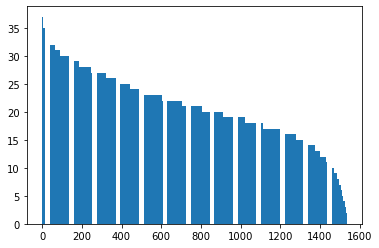

In [29]:
import matplotlib.pyplot as plt
plt.bar(range(len(counts)),counts)

In [203]:
# without scaling
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(data_set.iloc[:,3:-1])
kmeans.labels_
data_set["Group"] = kmeans.labels_

In [178]:
# with scaling
from sklearn.preprocessing import MinMaxScaler
new_set = MinMaxScaler().fit_transform(data_set.iloc[:,2:-2])
kmeans = KMeans(n_clusters=10, random_state=0).fit(new_set)
data_set["Group"] = kmeans.labels_

In [169]:
from sklearn.utils import shuffle
data_set = shuffle(data_set)
train_df,test_df = train_test_split(data_set,test_size=0.1)

In [98]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
  
n_estimators = [20,50,80,100,120,150,180,200]

# define different models#('SVR',SVR(max_iter=10000)),
models = [
    ('DT',DecisionTreeRegressor(random_state=42)),\
     #('ADBR',AdaBoostRegressor(random_state=42)), 
    ("GBR",GradientBoostingRegressor(random_state=42)),\
    ('BG',BaggingRegressor(random_state=42,n_jobs=-1)),
    ('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
    ('RF',RandomForestRegressor(n_jobs=-1,random_state=42)),
    ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),\
    ('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators = 200, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1))
    ]

# set search parameters grid for different models
para_grids = { #'SVR':{'kernel':['linear','poly','rbf','sigmoid','precomputed']},\
    'DT':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},\
    'ADBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2],'loss':['linear','square','exponential']},\
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'BG':{'n_estimators':[10,50,100]},\
    'ETR':{'n_estimators':n_estimators},\
    'RF':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,50],'learning_rate': [0.05,0.1,0.5,1],
    'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,30,50]}
    }

In [ ]:
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.metrics import r2_score,mean_squared_error
CV_results = []
for it in range(10):
    train_df,test_df = train_test_split(data_set,test_size=0.1)
    train_x = train_df.iloc[:,:-2]
    train_y = train_df.iloc[:,-2]
    test_x = test_df.iloc[:,:-2]
    test_y = test_df.iloc[:,-2]
    for model_name,model in models:
        result = GridSearchCV(model,para_grids[model_name],cv= 10,return_train_score=True,n_jobs=-1)
        result.fit(train_x,train_y)
        model_refit =model.set_params(**result.best_params_)
        train_cv = cross_validate(model_refit,train_x,train_y,cv = 10,scoring = ('r2', 'neg_mean_squared_error'))
        train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
        model_refit.fit(train_x,train_y)
        train_r2_cv = train_cv['test_r2'].mean()
        test_pre = model_refit.predict(test_x)
        test_r2 = r2_score(test_pre,test_y) 
        test_mse = mean_squared_error(test_y,test_pre)
        CV_results.append([it, model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_])
        print('Algorithm {}, Train_r2_cv {}, Train_mse_cv {}, Test_r2 {}, Test_error {}, best_params {}'.format(model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_))

In [ ]:
pd.DataFrame(CV_results).to_csv('./no grouping3.csv')

# Using the grouping information

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
CV_results = []
for it in range(10):
    train_df,test_df = train_test_split(data_set,test_size=0.1,stratify=data_set['Group'].values)
    train_x = train_df.iloc[:,:-2]
    train_y = train_df.iloc[:,-2]
    test_x = test_df.iloc[:,:-2]
    test_y = test_df.iloc[:,-2]
    for model_name,model in models:
        result = GridSearchCV(model,para_grids[model_name],cv= 10,return_train_score=True,n_jobs=-1)
        result.fit(train_x,train_y)
        model_refit =model.set_params(**result.best_params_)
        train_cv = cross_validate(model_refit,train_x,train_y,cv = 10,scoring = ('r2', 'neg_mean_squared_error'))
        train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
        model_refit.fit(train_x,train_y)
        train_r2_cv = train_cv['test_r2'].mean()
        test_pre = model_refit.predict(test_x)
        test_r2 = r2_score(test_pre,test_y) 
        test_mse = mean_squared_error(test_y,test_pre)
        CV_results.append([it, model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_])
        print('Algorithm {}, Train_r2_cv {}, Train_mse_cv {}, Test_r2 {}, Test_error {}, best_params {}'.format(model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_))

In [420]:
pd.DataFrame(CV_results).to_csv('./optic_grouping.csv')

In [368]:
from sklearn.preprocessing import MinMaxScaler

new_set = MinMaxScaler().fit_transform(data_set.iloc[:,3:-2])

In [369]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, 
                   init='random').fit_transform(new_set)

In [410]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(new_set)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1535 samples in 0.001s...
[t-SNE] Computed neighbors for 1535 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1535
[t-SNE] Computed conditional probabilities for sample 1535 / 1535
[t-SNE] Mean sigma: 0.061635
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.474548
[t-SNE] KL divergence after 500 iterations: 0.719425
t-SNE done! Time elapsed: 1.601776123046875 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

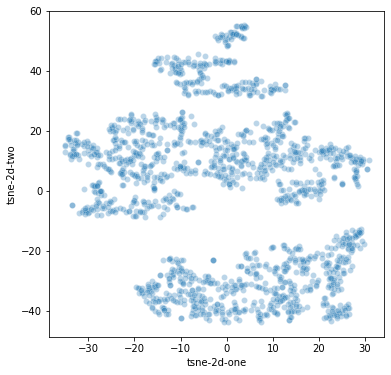

In [411]:
import seaborn as sns
import matplotlib.pyplot as plt
df_subset  = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    #hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [412]:
from sklearn.cluster import DBSCAN
dbscan_opt = DBSCAN(eps=5,min_samples=30)
dbscan_opt.fit(new_set)

DBSCAN(eps=5, min_samples=30)

In [413]:
df_subset['DBSCAN_opt_labels'] = dbscan_opt.labels_ 
#df_subset['DBSCAN_opt_labels']= dbscan_opt.value_counts()

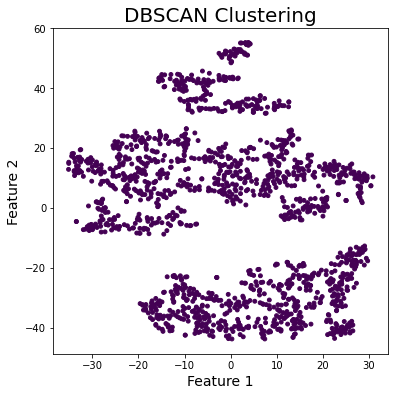

In [414]:

plt.figure(figsize =(6,6))
plt.scatter(df_subset['tsne-2d-one'],df_subset['tsne-2d-two'],c= df_subset['DBSCAN_opt_labels'],s=15)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

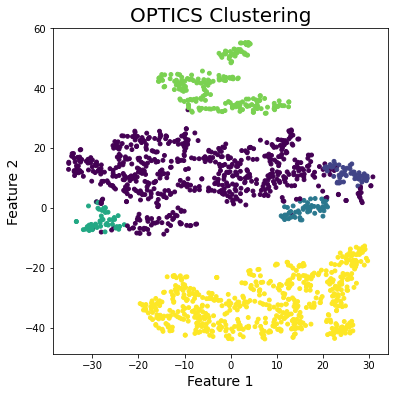

In [419]:
from sklearn.cluster import OPTICS
optic = OPTICS(eps = 1,min_samples=45)
optic.fit(df_subset.iloc[:,0:2])
df_subset['optic_labels'] = optic.labels_ 
plt.figure(figsize =(6,6))
plt.scatter(df_subset['tsne-2d-one'],df_subset['tsne-2d-two'],c= df_subset['optic_labels'],s=15)
plt.title('OPTICS Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

# Novel PAC analysis

In [30]:
data_set = pred_dataset(['CO2',])
data_set.head()

,S,V,L,BET,Vt,Temp(K),K,n,Vmic
31,0.28,0.2809,0.058,1479.0,0.7100,298.0,3.474703,0.687310,0.6300
32,0.28,0.2809,0.058,2264.0,1.0200,298.0,3.179363,0.763878,0.9200
33,0.28,0.2809,0.058,1778.0,1.0200,298.0,1.959096,0.786037,0.6700
38,0.28,0.2809,0.058,1470.0,0.6415,298.0,4.401633,0.442913,0.6304
39,0.28,0.2809,0.058,1470.0,0.6415,308.0,3.513874,0.469464,0.6304


In [31]:
from sklearn.preprocessing import MinMaxScaler
new_set = MinMaxScaler().fit_transform(data_set.iloc[:,2:-2])

In [33]:
new_set_trans = new_set.reshape(5,-1)
new_set_trans.shape

(5, 1535)

In [58]:
from sklearn.decomposition import SparsePCA,PCA,KernelPCA
transformer = KernelPCA(n_components=4, random_state=0)
transformer.fit(new_set_trans)
X_transformed = transformer.transform(new_set_trans)

In [66]:
# PCA
from sklearn.decomposition import SparsePCA,PCA,KernelPCA
transformer = PCA(n_components=4, random_state=0)
transformer.fit(new_set_trans)
X_transformed = transformer.transform(new_set_trans)
coeff_matrix = transformer.components_

In [81]:
threshold = [0.073,0.0743,0.081,0.077]
total_abnormal_index = []
for i in range(4):
    for j in range(len(coeff_matrix[i])):
        if np.abs(coeff_matrix[i][j])>=threshold[i]:
            total_abnormal_index.append(j)
#plt.hist(np.abs(coeff_matrix[3]))

In [115]:
from sklearn.ensemble import IsolationForest

model = IsolationForest().fit(data_set.iloc[:,-6:-1])
result = model.predict(data_set.iloc[:,-6:-1])

In [117]:
normal,abnormal = [],[]
for i in range(len(result)):
    if result[i]==-1:
        abnormal.append(i)
    else:
        normal.append(i)

In [84]:
abnormal_index = list(set(total_abnormal_index))


In [118]:
abnormal_data = data_set.iloc[abnormal,:]
#abnormal_data.to_csv('./abnormal_CO2.csv')
#plt.box(abnormal_data['Vt'].values)

In [119]:
normal_train = data_set.reset_index().drop(abnormal)
normal_train.drop(columns = ["index"],inplace =True)

In [120]:
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.metrics import r2_score,mean_squared_error
CV_results = []
for it in range(10):
    #train_df1,test_df1 = train_test_split(abnormal_data,test_size =0.1)
    #train_df2,test_df2 = train_test_split(normal_train,test_size =0.1)
    #train_df = pd.concat([train_df1, train_df2],axis=0)
    #test_df = pd.concat([test_df1,test_df2],axis=0)
    train_df,test_df =train_test_split(normal_train,test_size=0.1)
    train_x = train_df.iloc[:,-6:-1]
    train_y = train_df.iloc[:,-1]
    test_x = test_df.iloc[:,-6:-1]
    test_y = test_df.iloc[:,-1]
    for model_name,model in models:
        result = GridSearchCV(model,para_grids[model_name],cv= 10,return_train_score=True,n_jobs=-1)
        result.fit(train_x,train_y)
        model_refit =model.set_params(**result.best_params_)
        train_cv = cross_validate(model_refit,train_x,train_y,cv = 10,scoring = ('r2', 'neg_mean_squared_error'))
        train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
        model_refit.fit(train_x,train_y)
        train_r2_cv = train_cv['test_r2'].mean()
        test_pre = model_refit.predict(test_x)
        test_r2 = r2_score(test_pre,test_y) 
        test_mse = mean_squared_error(test_y,test_pre)
        CV_results.append([it, model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_])
        print('Algorithm {}, Train_r2_cv {}, Train_mse_cv {}, Test_r2 {}, Test_error {}, best_params {}'.format(model_name,train_r2_cv,train_mse_cv,test_r2,test_mse,result.best_params_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.59753953        nan 0.502301  ]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99862016]
  warnings.warn(


Algorithm DT, Train_r2_cv 0.5975395294273964, Train_mse_cv 0.027282623657553705, Test_r2 0.39657376260629285, Test_error 0.03498833412213741, best_params {'criterion': 'friedman_mse'}
Algorithm GBR, Train_r2_cv 0.7140541827102715, Train_mse_cv 0.01964308333186028, Test_r2 0.4830153191105021, Test_error 0.024490733493152485, best_params {'learning_rate': 0.1, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.7591495999070257, Train_mse_cv 0.016581815267438287, Test_r2 0.5388275157636777, Test_error 0.022600751270344412, best_params {'n_estimators': 50}
Algorithm ETR, Train_r2_cv 0.7656006240370552, Train_mse_cv 0.01632202904962435, Test_r2 0.5483983286553339, Test_error 0.02092271939180437, best_params {'n_estimators': 150}
Algorithm RF, Train_r2_cv 0.7597329353146106, Train_mse_cv 0.01655146693683017, Test_r2 0.5110266869616562, Test_error 0.02380696482702294, best_params {'n_estimators': 180}
Algorithm LGBM, Train_r2_cv 0.7359913091657793, Train_mse_cv 0.017871356779217414, Test_r2 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.57030389        nan 0.53586342]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99876545]
  warnings.warn(


Algorithm GBR, Train_r2_cv 0.6996051235497848, Train_mse_cv 0.020594071016059257, Test_r2 0.7006285289015222, Test_error 0.016728703644261173, best_params {'learning_rate': 0.5, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.720122004317308, Train_mse_cv 0.018952317195665026, Test_r2 0.7437336900789611, Test_error 0.012078155196733423, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.7240815239948103, Train_mse_cv 0.018698456592102054, Test_r2 0.7330500844176358, Test_error 0.012422111088543956, best_params {'n_estimators': 180}
Algorithm RF, Train_r2_cv 0.7235537454726476, Train_mse_cv 0.018718861212734143, Test_r2 0.7486007957874545, Test_error 0.012022162673047761, best_params {'n_estimators': 120}
Algorithm LGBM, Train_r2_cv 0.6962391472879967, Train_mse_cv 0.020717032494375242, Test_r2 0.6854096924273079, Test_error 0.013437729813963028, best_params {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 50}
Algorithm BGLGBM, Train_r2_cv 0.6960605165521605, Train

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.53828627        nan 0.54798996]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99925129]
  warnings.warn(


Algorithm DT, Train_r2_cv 0.5479899611455736, Train_mse_cv 0.030560763686527586, Test_r2 0.4673213031280987, Test_error 0.049169057709923664, best_params {'criterion': 'poisson'}
Algorithm GBR, Train_r2_cv 0.7144351211944453, Train_mse_cv 0.019300839449343087, Test_r2 0.6342379554525114, Test_error 0.022877973183145158, best_params {'learning_rate': 0.1, 'n_estimators': 180}
Algorithm BG, Train_r2_cv 0.7366321762860168, Train_mse_cv 0.017662988141836207, Test_r2 0.6923585900280593, Test_error 0.01910147808380734, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.7420859865569016, Train_mse_cv 0.017267042740014706, Test_r2 0.6721414007064346, Test_error 0.021476384290352445, best_params {'n_estimators': 200}
Algorithm RF, Train_r2_cv 0.7405747560983984, Train_mse_cv 0.017430765877612435, Test_r2 0.6953910443652936, Test_error 0.018913618174725273, best_params {'n_estimators': 200}
Algorithm LGBM, Train_r2_cv 0.7193500580248641, Train_mse_cv 0.018986699679610437, Test_r2 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.56189384        nan 0.54142169]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99994807]
  warnings.warn(


Algorithm GBR, Train_r2_cv 0.6995744320773281, Train_mse_cv 0.0205118060413856, Test_r2 0.3627252845650044, Test_error 0.026564285587853738, best_params {'learning_rate': 0.1, 'n_estimators': 100}
Algorithm BG, Train_r2_cv 0.7397083386716348, Train_mse_cv 0.01782737690881541, Test_r2 0.48911833698315954, Test_error 0.021770942807078725, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.7258395418067114, Train_mse_cv 0.018486679487205875, Test_r2 0.5768397301089296, Test_error 0.01902535262792518, best_params {'n_estimators': 120}
Algorithm RF, Train_r2_cv 0.7387227137200283, Train_mse_cv 0.01786183742508722, Test_r2 0.5056856942033996, Test_error 0.021241453892073422, best_params {'n_estimators': 200}
Algorithm LGBM, Train_r2_cv 0.7114854776881316, Train_mse_cv 0.019544901845012147, Test_r2 0.4837396884260098, Test_error 0.02279527696441094, best_params {'learning_rate': 0.05, 'n_estimators': 120, 'num_leaves': 50}
Algorithm BGLGBM, Train_r2_cv 0.7142372040944474, Train_ms

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.58446282        nan 0.51768228]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99886923]
  warnings.warn(


Algorithm DT, Train_r2_cv 0.5844628217391304, Train_mse_cv 0.027102319874647722, Test_r2 0.7610579457111156, Test_error 0.019910670890218616, best_params {'criterion': 'friedman_mse'}
Algorithm GBR, Train_r2_cv 0.7163695637058065, Train_mse_cv 0.018483522931310854, Test_r2 0.5943619484298026, Test_error 0.02554163238072365, best_params {'learning_rate': 0.1, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.7286697582519746, Train_mse_cv 0.017628311426294067, Test_r2 0.7232857188549064, Test_error 0.017454505117889086, best_params {'n_estimators': 50}
Algorithm ETR, Train_r2_cv 0.7273471774034554, Train_mse_cv 0.017787363644286937, Test_r2 0.6341632191228919, Test_error 0.023095833523076044, best_params {'n_estimators': 50}
Algorithm RF, Train_r2_cv 0.7274933224926684, Train_mse_cv 0.017716923227341596, Test_r2 0.6946821050681525, Test_error 0.01865555978112787, best_params {'n_estimators': 200}
Algorithm LGBM, Train_r2_cv 0.7207795967156087, Train_mse_cv 0.01828258432857758, Test_r2 0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.54982585        nan 0.54467851]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99904003]
  warnings.warn(


Algorithm GBR, Train_r2_cv 0.7256335222188536, Train_mse_cv 0.019128851190552205, Test_r2 0.4849691320097881, Test_error 0.024639178018192702, best_params {'learning_rate': 0.1, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.7567974187969415, Train_mse_cv 0.016985988825700276, Test_r2 0.5526379961454009, Test_error 0.019981703514903956, best_params {'n_estimators': 50}
Algorithm ETR, Train_r2_cv 0.7535586533719723, Train_mse_cv 0.01701662215362685, Test_r2 0.5733847090928603, Test_error 0.020505576647903034, best_params {'n_estimators': 50}
Algorithm RF, Train_r2_cv 0.7594820935962352, Train_mse_cv 0.01675908722968501, Test_r2 0.5763668845355665, Test_error 0.018946704295777828, best_params {'n_estimators': 180}
Algorithm LGBM, Train_r2_cv 0.7432284479363076, Train_mse_cv 0.017891844620221642, Test_r2 0.45814035608300174, Test_error 0.025084255669324387, best_params {'learning_rate': 0.1, 'n_estimators': 80, 'num_leaves': 30}
Algorithm BGLGBM, Train_r2_cv 0.7415888951832572, Train_ms

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.59669284        nan 0.54130937]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99897662]
  warnings.warn(


Algorithm DT, Train_r2_cv 0.5966928414363994, Train_mse_cv 0.027169477937648956, Test_r2 0.5182409844441704, Test_error 0.03251811244274809, best_params {'criterion': 'friedman_mse'}
Algorithm GBR, Train_r2_cv 0.7219210885391663, Train_mse_cv 0.01892311090353871, Test_r2 0.5709046851527496, Test_error 0.02289738977436422, best_params {'learning_rate': 0.1, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.7351085185401514, Train_mse_cv 0.018005271295240217, Test_r2 0.6554679730034222, Test_error 0.01811110087043897, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.7360975919875108, Train_mse_cv 0.017881608981047577, Test_r2 0.7045454362759134, Test_error 0.0161241767407512, best_params {'n_estimators': 200}
Algorithm RF, Train_r2_cv 0.7405530593832579, Train_mse_cv 0.01765498273440893, Test_r2 0.660646439029858, Test_error 0.018016931154361805, best_params {'n_estimators': 200}
Algorithm LGBM, Train_r2_cv 0.722772161182887, Train_mse_cv 0.018839285645573255, Test_r2 0.6027

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.5414826         nan 0.38792947]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99892988]
  warnings.warn(


Algorithm GBR, Train_r2_cv 0.6714629728373979, Train_mse_cv 0.02211041738753809, Test_r2 0.582826195464489, Test_error 0.016112671487810235, best_params {'learning_rate': 0.1, 'n_estimators': 50}
Algorithm BG, Train_r2_cv 0.7051759382543381, Train_mse_cv 0.01992206016971195, Test_r2 0.6630172654187858, Test_error 0.01400095771145142, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.709377254823534, Train_mse_cv 0.019274301738412852, Test_r2 0.742730961050556, Test_error 0.011120200353644985, best_params {'n_estimators': 120}
Algorithm RF, Train_r2_cv 0.707534694961153, Train_mse_cv 0.019750935660567112, Test_r2 0.6746076756682025, Test_error 0.013644063021941655, best_params {'n_estimators': 120}
Algorithm LGBM, Train_r2_cv 0.6963568061967086, Train_mse_cv 0.020782179756243496, Test_r2 0.5200328033765373, Test_error 0.016203076348062142, best_params {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 50}
Algorithm BGLGBM, Train_r2_cv 0.6944813970549447, Train_mse_cv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.53614207        nan 0.57325229]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99995057]
  warnings.warn(


Algorithm DT, Train_r2_cv 0.5732522884231026, Train_mse_cv 0.028792494655320678, Test_r2 0.3985164531111125, Test_error 0.041158207691979254, best_params {'criterion': 'poisson'}
Algorithm GBR, Train_r2_cv 0.6965458069097303, Train_mse_cv 0.020228279031338003, Test_r2 0.5777566770018903, Test_error 0.020160874532580912, best_params {'learning_rate': 0.1, 'n_estimators': 180}
Algorithm BG, Train_r2_cv 0.7289569504176587, Train_mse_cv 0.01814502908735965, Test_r2 0.6215746993614868, Test_error 0.017717990189266588, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.732280128121204, Train_mse_cv 0.0179605839536549, Test_r2 0.636368490791035, Test_error 0.01745615461472568, best_params {'n_estimators': 120}
Algorithm RF, Train_r2_cv 0.7320697919752569, Train_mse_cv 0.017955667183237302, Test_r2 0.6198490884432529, Test_error 0.017873019584644895, best_params {'n_estimators': 120}
Algorithm LGBM, Train_r2_cv 0.7133484449316981, Train_mse_cv 0.019161952752341425, Test_r2 0.507246

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.62140351        nan 0.55495801]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan 1.                nan 0.99922357]
  warnings.warn(


Algorithm GBR, Train_r2_cv 0.7386019373060739, Train_mse_cv 0.018296460225540365, Test_r2 0.49605462828092817, Test_error 0.024752920150953144, best_params {'learning_rate': 0.1, 'n_estimators': 200}
Algorithm BG, Train_r2_cv 0.764444988878797, Train_mse_cv 0.01652023725192978, Test_r2 0.5180781160943699, Test_error 0.024555945713442367, best_params {'n_estimators': 100}
Algorithm ETR, Train_r2_cv 0.7715052853801408, Train_mse_cv 0.015974596331391, Test_r2 0.5805113975466103, Test_error 0.02212891937482542, best_params {'n_estimators': 100}
Algorithm RF, Train_r2_cv 0.7633138217120862, Train_mse_cv 0.016602171199788764, Test_r2 0.5141434308160655, Test_error 0.024701673679077208, best_params {'n_estimators': 80}
Algorithm LGBM, Train_r2_cv 0.7543999628001142, Train_mse_cv 0.017166425589213764, Test_r2 0.4998586115001932, Test_error 0.027330274452450735, best_params {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 50}
Algorithm BGLGBM, Train_r2_cv 0.7508799768180616, Train_mse

In [121]:
pd.DataFrame(CV_results).to_csv('./ir_grouping.csv')

In [44]:
transformer.singular_values_

array([5.70465464e+00, 5.60163529e+00, 5.38231928e+00, 4.96894149e+00,
       1.92342882e-15])

In [46]:
n_samples =5
X_centered = new_set_trans - np.mean(new_set_trans, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = transformer.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, transformer.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)

6.508616918242007
8.1357711478025
6.2756635865275445
7.844579483159433
5.793872172651735
7.242340215814676
4.938075908432152
6.172594885540199
-3.985594802978176e-18
9.248946088139281e-31
